### Step 1: Install and Import Required Libraries

We start by installing `openpyxl` to support Excel file reading, then import all necessary libraries for data analysis and visualization.

In [ ]:
!pip install openpyxl

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load the Online Retail Dataset

Load the dataset into a pandas DataFrame. Ensure that the file `Online Retail.xlsx` is uploaded to your Colab environment.


In [ ]:
file_path = '/content/Online Retail.xlsx'
df = pd.read_excel(file_path, sheet_name='Online Retail')

### Step 3: Clean the Data

We filter out rows with missing `CustomerID` values, convert `InvoiceDate` to datetime format, and cast `CustomerID` to integer for consistency.


In [ ]:
df = df[df['CustomerID'].notnull()]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype(int)

### Step 4: Create InvoiceMonth and CohortMonth Columns

- `InvoiceMonth`: month when each transaction occurred.
- `CohortMonth`: the first month a customer made a purchase (used to define their cohort).


In [ ]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp()
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

### Step 5: Calculate Cohort Index

Cohort Index represents how many months have passed since a user’s first purchase. This helps track behavior over time from the start of their journey.


In [ ]:
year_diff = df['InvoiceMonth'].dt.year - df['CohortMonth'].dt.year
month_diff = df['InvoiceMonth'].dt.month - df['CohortMonth'].dt.month
df['CohortIndex'] = year_diff * 12 + month_diff

### Step 6: Create the Retention Matrix

We count unique users per cohort and cohort index (months since signup), then pivot the table to create a matrix where each row is a cohort and each column is a month.


In [ ]:
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

### Step 7: Normalize the Retention Matrix

To understand retention rates, we divide each row by the number of users in the cohort (month 0), resulting in a percentage-based matrix.


In [ ]:
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0).round(3)

### Step 8: Plot Retention Heatmap

We visualize the retention matrix as a heatmap to easily observe user retention trends across cohorts.


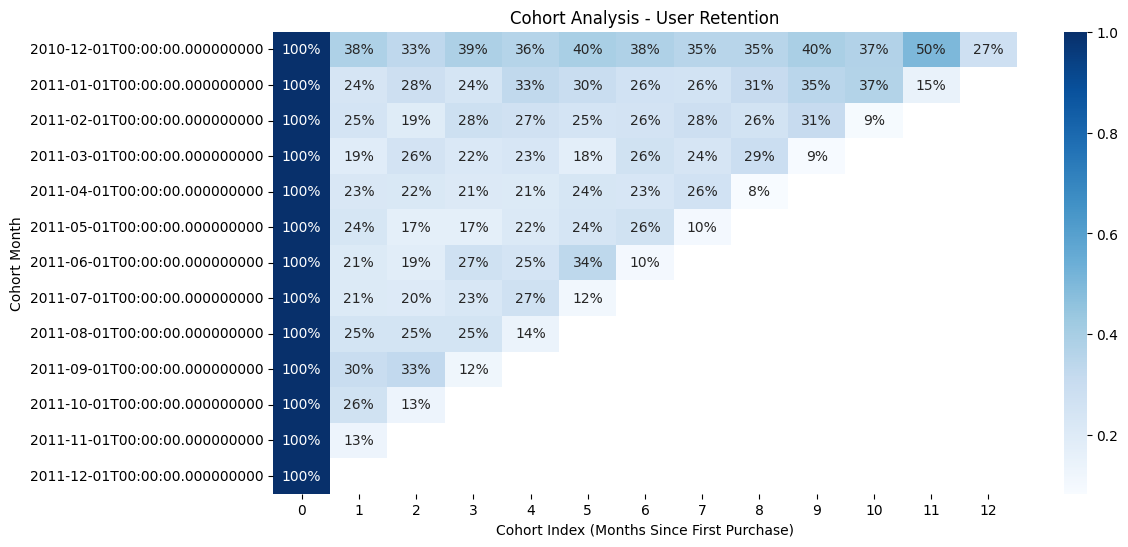

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix, annot=True, fmt=".0%", cmap='Blues')
plt.title('Cohort Analysis - User Retention')
plt.xlabel('Cohort Index (Months Since First Purchase)')
plt.ylabel('Cohort Month')
plt.show()

###  Retention Curves by Cohort

This plot shows how retention changes over time for a few selected cohorts. Each line represents a cohort’s retention curve over time.


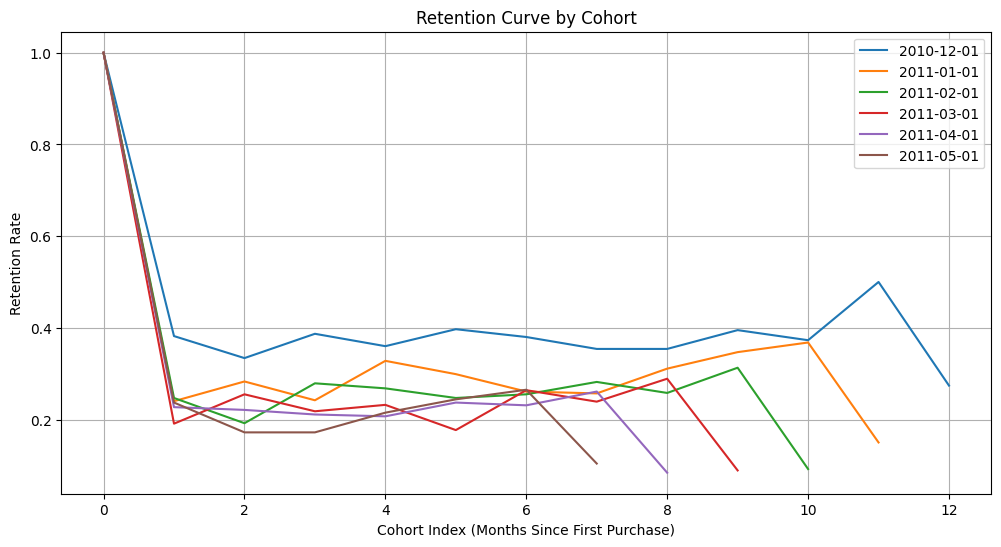

In [ ]:
plt.figure(figsize=(12, 6))

num_cohorts_to_plot = 6
for i, cohort in enumerate(retention_matrix.index[:num_cohorts_to_plot]):
    plt.plot(retention_matrix.columns, retention_matrix.loc[cohort], label=str(cohort.date()))

plt.title('Retention Curve by Cohort')
plt.xlabel('Cohort Index (Months Since First Purchase)')
plt.ylabel('Retention Rate')
plt.legend()
plt.grid(True)
plt.show()

###  Average Retention by Month

This chart shows the average retention rate across all cohorts for each month. It gives a general sense of retention decay.


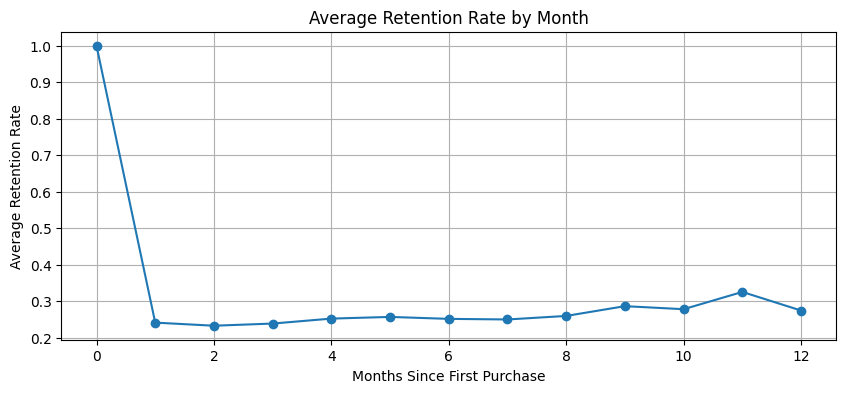

In [ ]:
avg_retention = retention_matrix.mean()

plt.figure(figsize=(10, 4))
avg_retention.plot(marker='o')
plt.title('Average Retention Rate by Month')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Average Retention Rate')
plt.grid(True)
plt.show()


###  Monthly Active Users (MAU)

This line chart shows how many unique customers were active each month. It helps analyze engagement and growth over time.


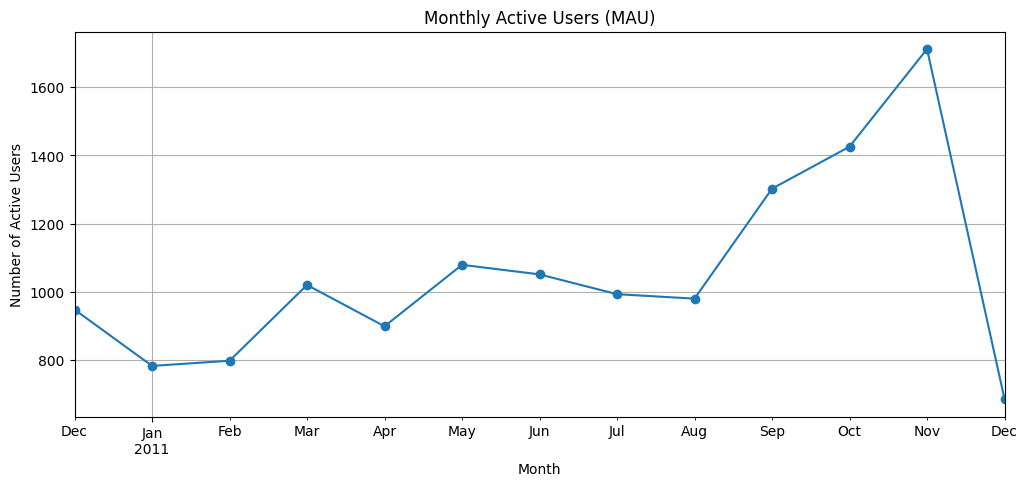

In [ ]:
monthly_active_users = df.groupby('InvoiceMonth')['CustomerID'].nunique()

plt.figure(figsize=(12, 5))
monthly_active_users.plot(marker='o')
plt.title('Monthly Active Users (MAU)')
plt.xlabel('Month')
plt.ylabel('Number of Active Users')
plt.grid(True)
plt.show()